In [1]:
from lvc.datasets.vimeo90k import Vimeo90kDatasetConsecutive, Vimeo90kDatasetIntervals

In [2]:
from matplotlib import pyplot as plt
from torchvision import transforms
import random
import math

In [3]:
paths = ('/Users/begaintj/data/vimeo90k/vimeo_septuplet/', '/data/lvc/originals/vimeo_septuplet/')

for p in paths:
    try:
        dataset = Vimeo90kDatasetIntervals(p, patch_size=(256, 384), intervals=[1, 2, 3])
        break
    except ValueError:
        continue

In [4]:
print(len(dataset))

64612


In [5]:
sample = dataset[0]
print(len(sample))

3


In [6]:
len([item.flip(-1) for item in sample])

3

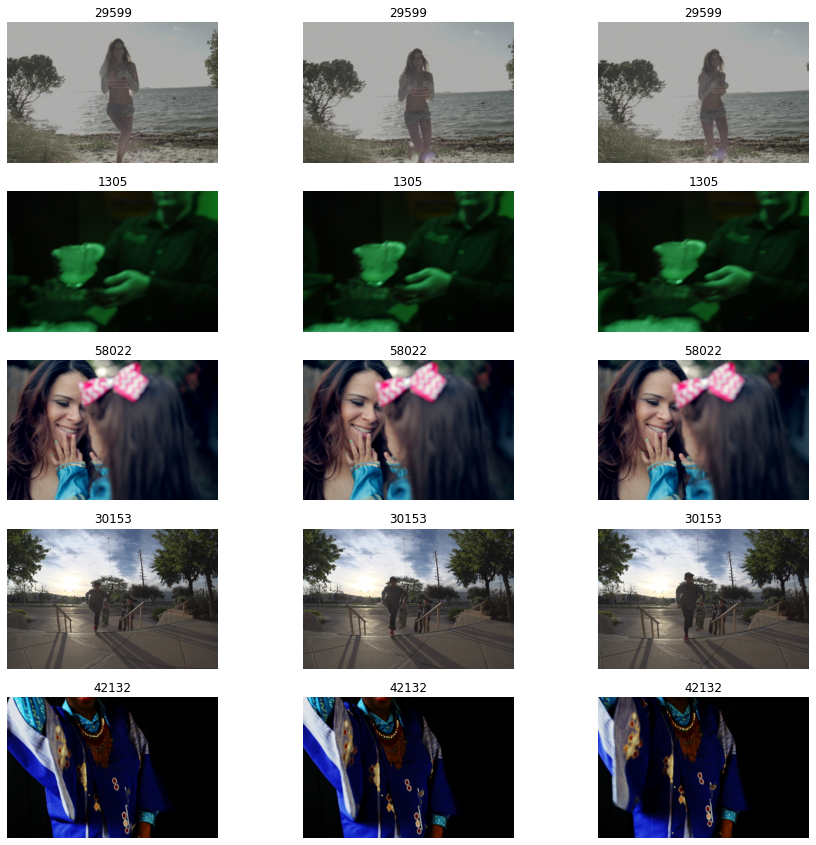

In [7]:
N = 5
fig, axes = plt.subplots(5, len(sample), figsize=(5*len(sample), 3*N))
for i in range(N):
    idx = random.randint(0, len(dataset))
    sample = dataset[idx]
#     sample = [item.flip(-1) for item in sample]
    for c, (ax, tensor) in enumerate(zip(axes[i], sample)):
        ax.imshow(transforms.ToPILImage()(tensor))
        ax.set_title(idx)
        ax.axis('off')

## Load model from checkpoint

In [33]:
from lvc.models.networks.video.ssf import google2020_ssf
import torch
# path = '/home/begaintj/dev/learned-video-compression/logs/lvc/google2020_ssf-0.01230-1e-4-8-cd906f75-2021-08-02-10h43/ckpt_best_loss_model.pth.tar'
path = '/home/begaintj/dev/learned-video-compression/logs/lvc/google2020_ssf-0.01230-1e-4-8-cd906f75-2021-07-29-19h40/ckpt_last_model.pth.tar'

# device = 'cpu'
device = 'cuda'

net = google2020_ssf()
net.load_state_dict(torch.load(path, map_location=device)['network'])
net.eval()
print(net.training)

False


## Select random sample

In [34]:
idx = random.randint(0, len(dataset))
# idx = 64314
idx = 29599
sample = dataset[idx]

In [35]:
print(idx)

29599


## Inference

In [36]:
# sample = sample[::-1]

In [37]:
with torch.no_grad():
    data = [x.unsqueeze(0) for x in sample]
    out = net(data)

In [38]:
for a, b in zip(data, out['x_hat']):
    print('{:.3f} dB'.format(-10*torch.log10((a-b).pow(2).mean()).item()))

34.981 dB
34.989 dB
34.880 dB


## Detailed inference

In [39]:
from lvc.models.networks.video.ssf import gaussian_volume, warp_volume

In [56]:
reconstructions = []
flows = []
sfs = []
predictions = []
residuals = []

with torch.no_grad():
    for i, frame in enumerate(sample):
        frame = frame.unsqueeze(0)
        if i == 0:  # keyframe
            y = net.img_encoder(frame)
            y_hat, _ = net.img_hyperprior(y)
            rec = net.img_decoder(y_hat)
            
            flows.append(None)
            predictions.append(None)
            sfs.append(None)
            residuals.append(None)
            
        else: # P-frame
            x = torch.cat((frame, rec), dim=1)
            y = net.motion_encoder(x)
            y_hat, _ = net.motion_hyperprior(y)
            motion = net.motion_decoder(y_hat)
            flow, sf = motion.chunk(2, dim=1)
            flow = torch.tanh(flow)
            sf = torch.tanh(sf + 1)
            
            volume = gaussian_volume(rec, net.sigma0, net.num_levels)
            pred = warp_volume(volume, flow, sf)
            
            flows.append(flow)
            sfs.append(sf)
            predictions.append(pred)
            
            res = frame - pred
            y = net.res_encoder(res)
            y_hat, _ = net.res_hyperprior(y)
            res = net.res_decoder(y_hat)
            residuals.append(res)
            rec = res + pred
            
        reconstructions.append(rec)

## Visu

In [51]:
from lvc.models.networks.flows.flow_utils import vis_flow

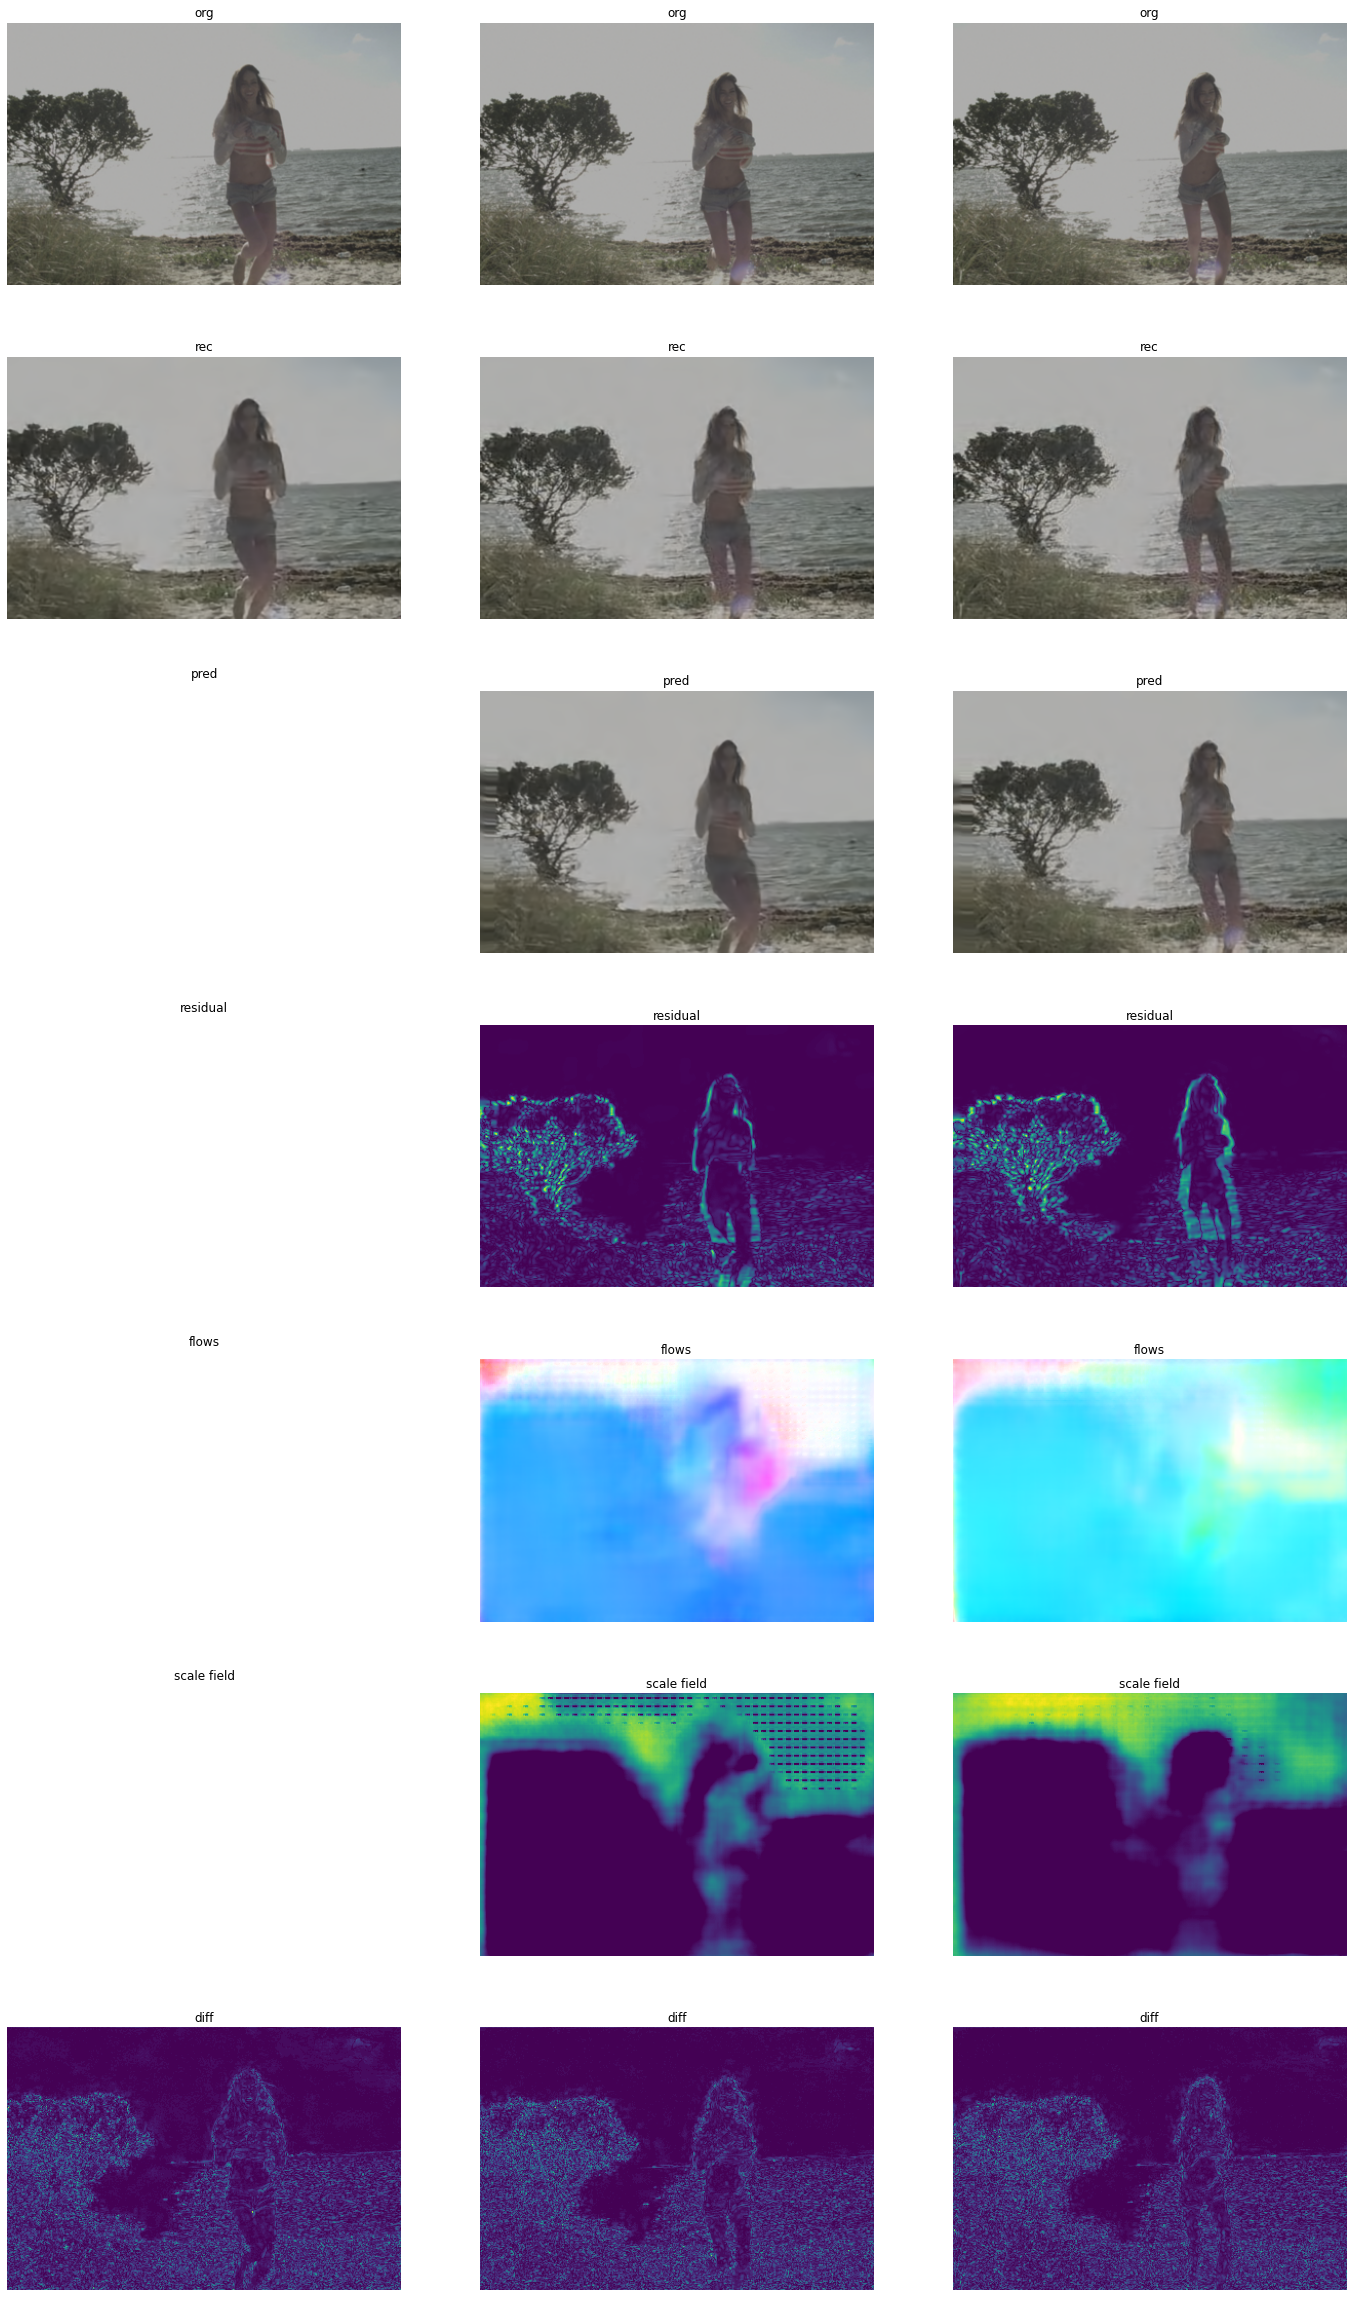

In [52]:
N = 7
fig, axes = plt.subplots(N, len(sample), figsize=(8*len(sample), 6*N))
for i in range(N):
    cmap = 'viridis'
    tensors = data
    if i == 0:
        tensors = data
        title = 'org'
    elif i == 1:
        tensors = reconstructions
        title = 'rec'
    elif i == 2:
        tensors = predictions
        title = 'pred'
    elif i == 3:
        tensors = residuals
        tensors = [t.mean(1, keepdim=True).abs() if t is not None else t for t in tensors]
        title = 'residual'
    elif i == 4:
        title = 'flows'
        tensors = flows
        tensors = [vis_flow(t.squeeze().numpy()) if t is not None else t for t in tensors]
    elif i == 5:
        tensors = sfs
        tensors = [t.add(1).div(2.) if t is not None else t for t in tensors]
        title = 'scale field'
    else:
        tensors = [(a-b).abs().mean(1, keepdim=True) for a, b in zip(data, out['x_hat'])]
        title = 'diff'
    for c, (ax, tensor) in enumerate(zip(axes[i], tensors)):
        if tensor is not None:
            if isinstance(tensor, torch.Tensor):
                im = ax.imshow(transforms.ToPILImage()(tensor.squeeze().clamp(0, 1)), cmap=cmap)
            else:
                im = ax.imshow(tensor, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')

In [53]:
from lvc.models.networks.video.ssf import gaussian_volume
volume = gaussian_volume(data[0], 1.5, 5)

In [54]:
2 * int(math.ceil(3 * 1.5)) + 1

11

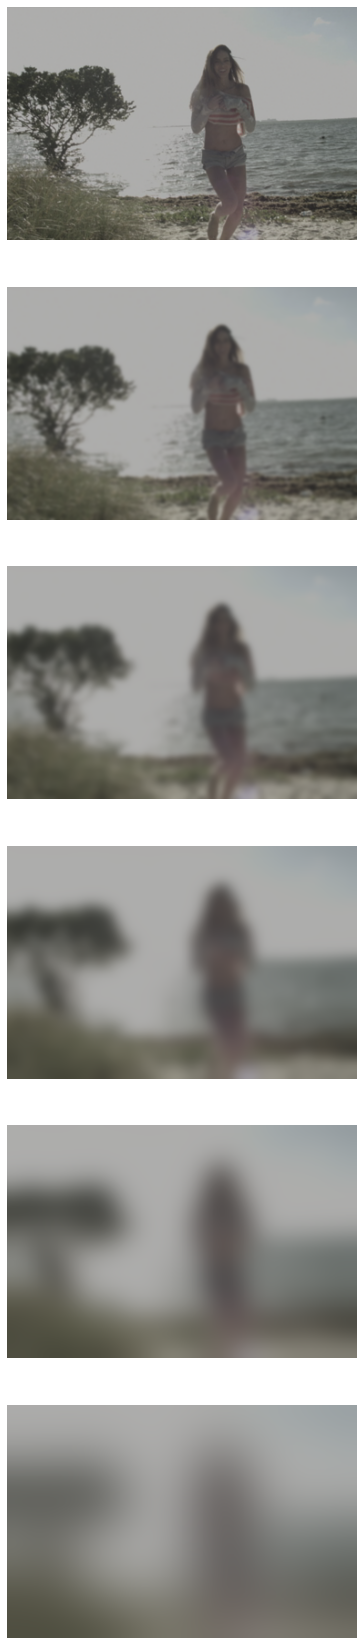

In [55]:
fig, axes = plt.subplots(volume.size(2), 1, figsize=(9, 5*volume.size(2)))
for i, ax in enumerate(axes):
    ax.imshow(transforms.ToPILImage()(volume[:, :, i].squeeze()))
    ax.axis('off')
plt.show()